In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ───────── CONFIG ─────────
DATA_PATH       = "prices_2020.csv"
TICKERS         = ["QZ","ES","CO","CL","RX","JY"]

# Default strategy parameters (edit here to experiment)
MA_PARAMS       = [(20, 60)]               # list of (fast, slow) windows
RSI_PARAMS      = [(14, 30, 70)]           # list of (lookback, low, high)

INITIAL_CAPITAL = 100_000
TRADING_DAYS    = 252


In [ ]:
# ─────────────── UTILITIES ───────────────
def load_data(path):
    df = pd.read_csv(path, dayfirst=True, parse_dates=["Date","Expiry"])
    df = df.sort_values(["Date","ContractCode"])
    return df

def build_front_month(df, ticker):
    """ Returns a Date-indexed DataFrame with only the front-month Price series. """
    sub = df[df["Ticker"] == ticker]
    # take earliest-contract per date
    front = sub.groupby("Date", as_index=False).first()[["Date","DailySettlePrice"]]
    front = front.set_index("Date").rename(columns={"DailySettlePrice":"Price"})
    # Convert the 'Price' column to numeric, coercing errors to NaN
    front["Price"] = pd.to_numeric(front["Price"], errors="coerce")
    # Drop rows where 'Price' is NaN after conversion
    front.dropna(subset=["Price"], inplace=True)
    return front

def performance_metrics(equity, strat_ret):
    total_ret = (equity[-1]/equity[0] - 1)*100
    ann_vol   = strat_ret.std() * np.sqrt(TRADING_DAYS) * 100
    sharpe    = strat_ret.mean()/strat_ret.std() * np.sqrt(TRADING_DAYS)
    # drawdown
    peaks = equity.cummax()
    dd = (equity - peaks)/peaks
    max_dd = dd.min()*100
    dd_date = dd.idxmin()
    return {
        "TotalReturn(%)": total_ret,
        "AnnVol(%)":      ann_vol,
        "Sharpe":         sharpe,
        "MaxDD(%)":       max_dd,
        "MaxDDDate":      dd_date
    }

# 1. Trend-following strategy – Moving Average (MA) Crossover

In [ ]:
# ─── STRATEGY: MA Crossover ───
def ma_crossover(front, fast, slow):
    df = front.copy()
    df["MA_fast"]       = df["Price"].rolling(fast).mean()
    df["MA_slow"]       = df["Price"].rolling(slow).mean()
    df["Signal"]        = (df["MA_fast"]>df["MA_slow"]).astype(int)
    df["Position"]      = df["Signal"].shift().fillna(0)
    df["Return"]        = df["Price"].pct_change().fillna(0)
    df["StrategyReturn"]= df["Position"]*df["Return"]
    df["Equity"]        = (1+df["StrategyReturn"]).cumprod()*INITIAL_CAPITAL

    # count trades & wins
    trades = df["Signal"].diff().abs().sum()
    wins   = ((df["Position"]==1)&(df["Return"]>0)).sum()
    return df, int(trades), int(wins)

# Collect MA summary
df_raw = load_data(DATA_PATH)
records_ma = []

for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)
    for fast, slow in MA_PARAMS:
        ma_df, num_trades, winning_trades = ma_crossover(front, fast, slow)
        metrics = performance_metrics(ma_df["Equity"], ma_df["StrategyReturn"])
        tr = metrics["TotalReturn(%)"]
        sr = metrics["Sharpe"]
        loss_trades = num_trades - winning_trades
        records_ma.append({
            "Ticker":ticker,
            "MA":f"{fast}-{slow}",
            "Total Ret (%)":tr,
            "Sharpe":sr,
            "Trades":num_trades,
            "Win Rate (%)": round(winning_trades/num_trades*100 if num_trades else 0,2),
            "W":winning_trades,
            "L":loss_trades,
            "Final Equity":round(ma_df["Equity"].iloc[-1],2)
        })

summary_ma = pd.DataFrame(records_ma)
print("❇️ MA Summary:")
print(summary_ma.to_string(index=False))
print()

❇️ MA Summary:
Ticker    MA  Total Ret (%)   Sharpe  Trades  Win Rate (%)  W   L  Final Equity
    QZ 20-60       4.084486 0.400552       5        840.00 42 -37     104084.49
    ES 20-60      27.766491 1.686586       3       3200.00 96 -93     127766.49
    CO 20-60      10.417383 0.662510       3       1900.00 57 -54     110417.38
    CL 20-60      17.094121 0.912782       3       1866.67 56 -53     117094.12
    RX 20-60       2.630034 0.686153       7       1000.00 70 -63     102630.03
    JY 20-60       0.194258 0.064124       5       1760.00 88 -83     100194.26



<ipython-input-41-3905379258>:3: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, dayfirst=True, parse_dates=["Date","Expiry"])
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_ret = (equity[-1]/equity[0] - 1)*100
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_ret = (equity[-1]/equity[0] - 1)*100
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

📊 MA Visualizations:


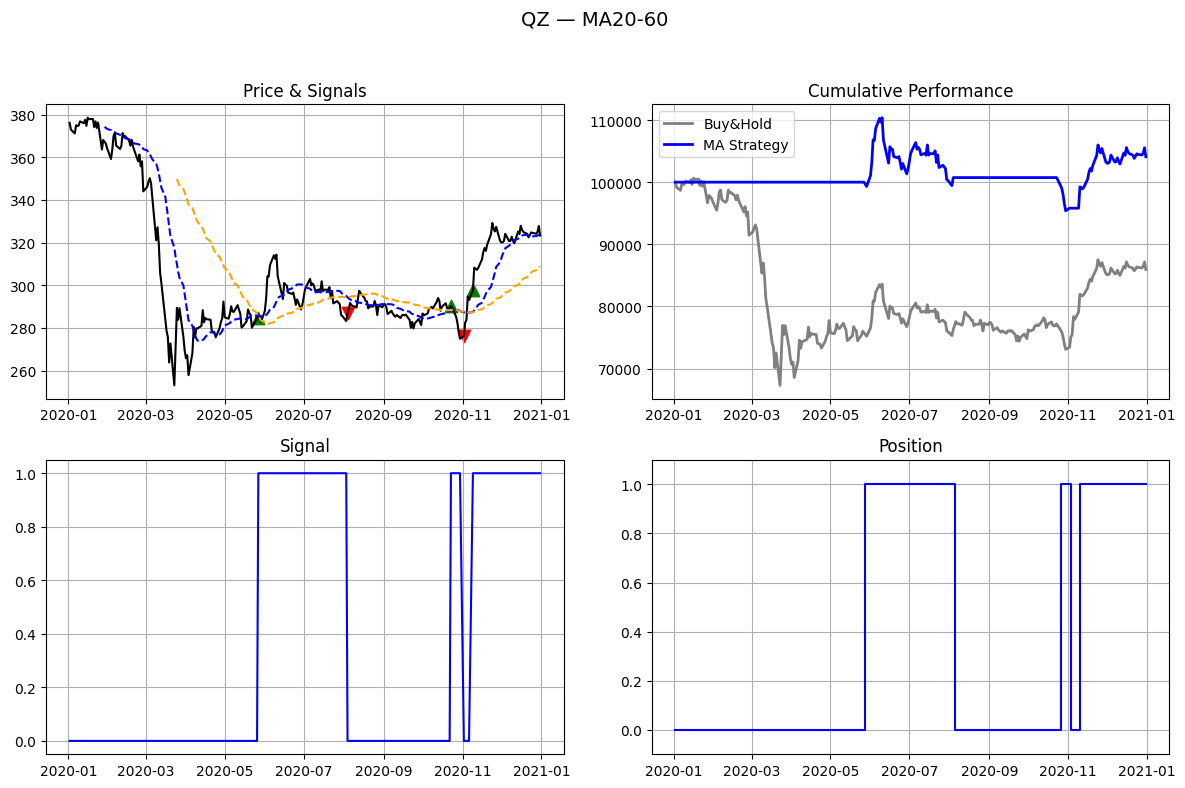

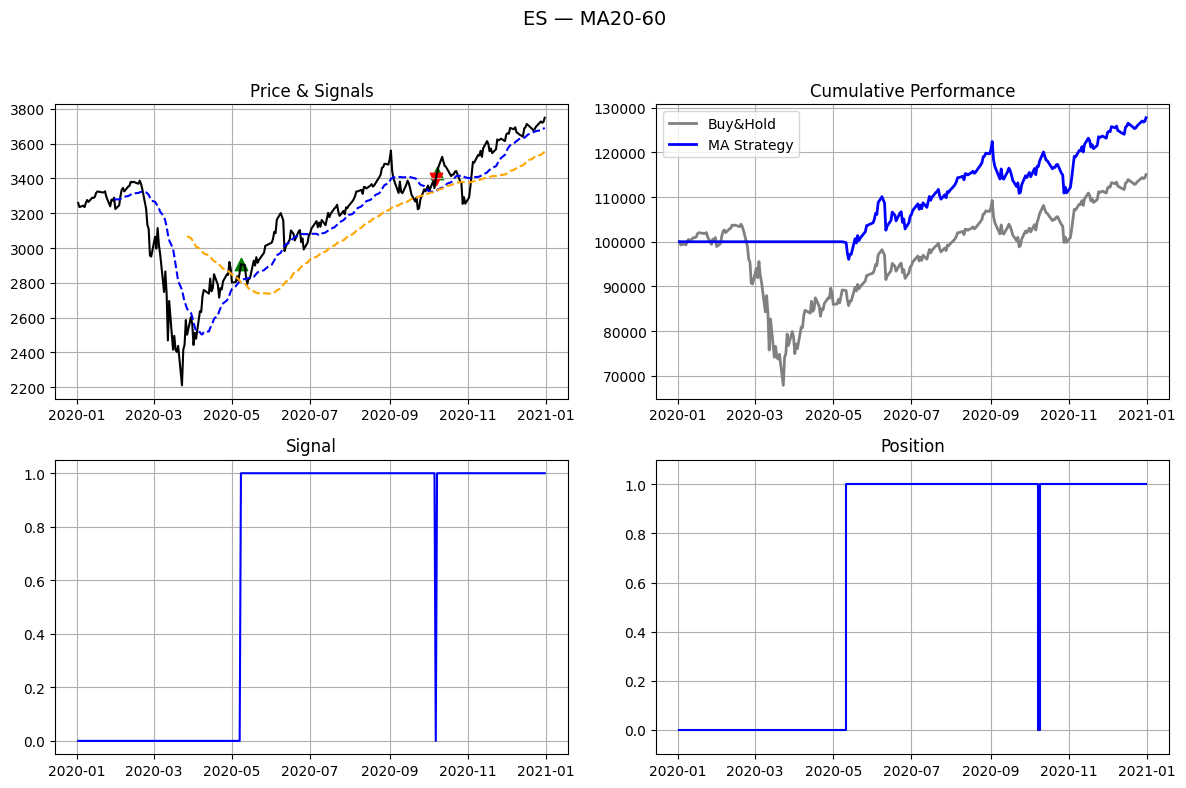

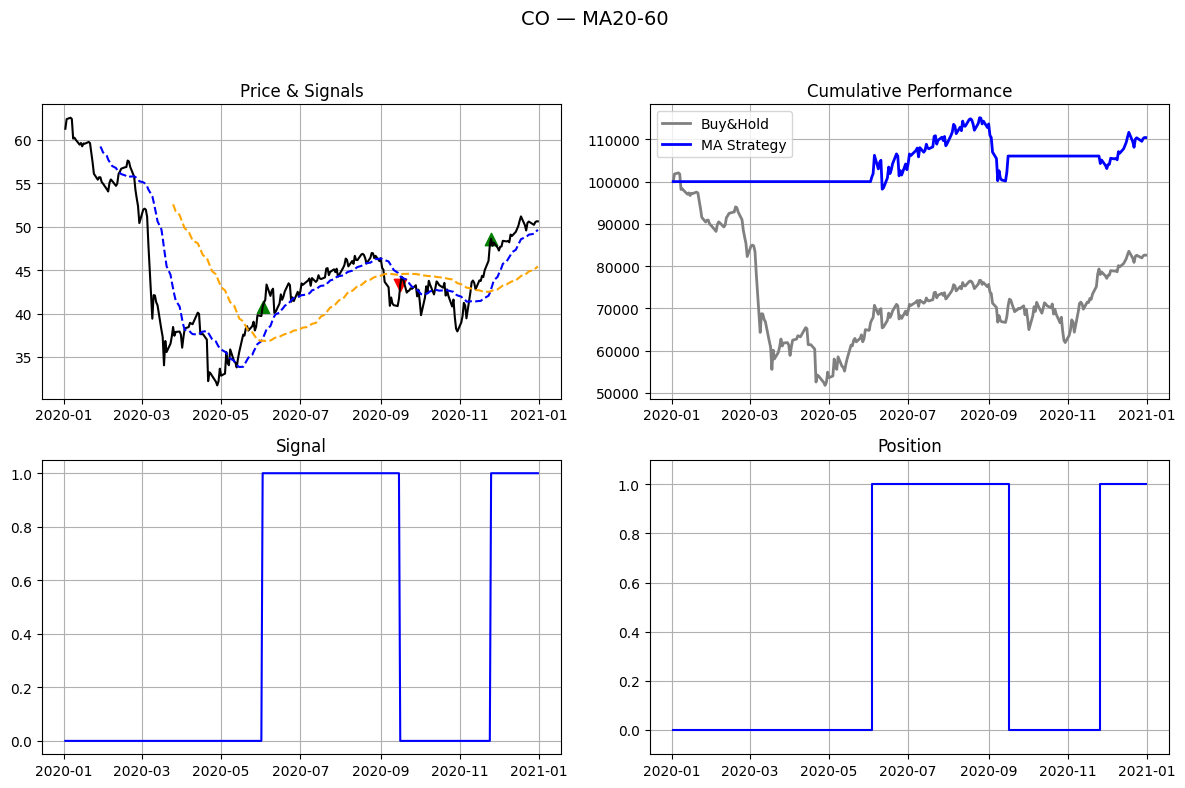

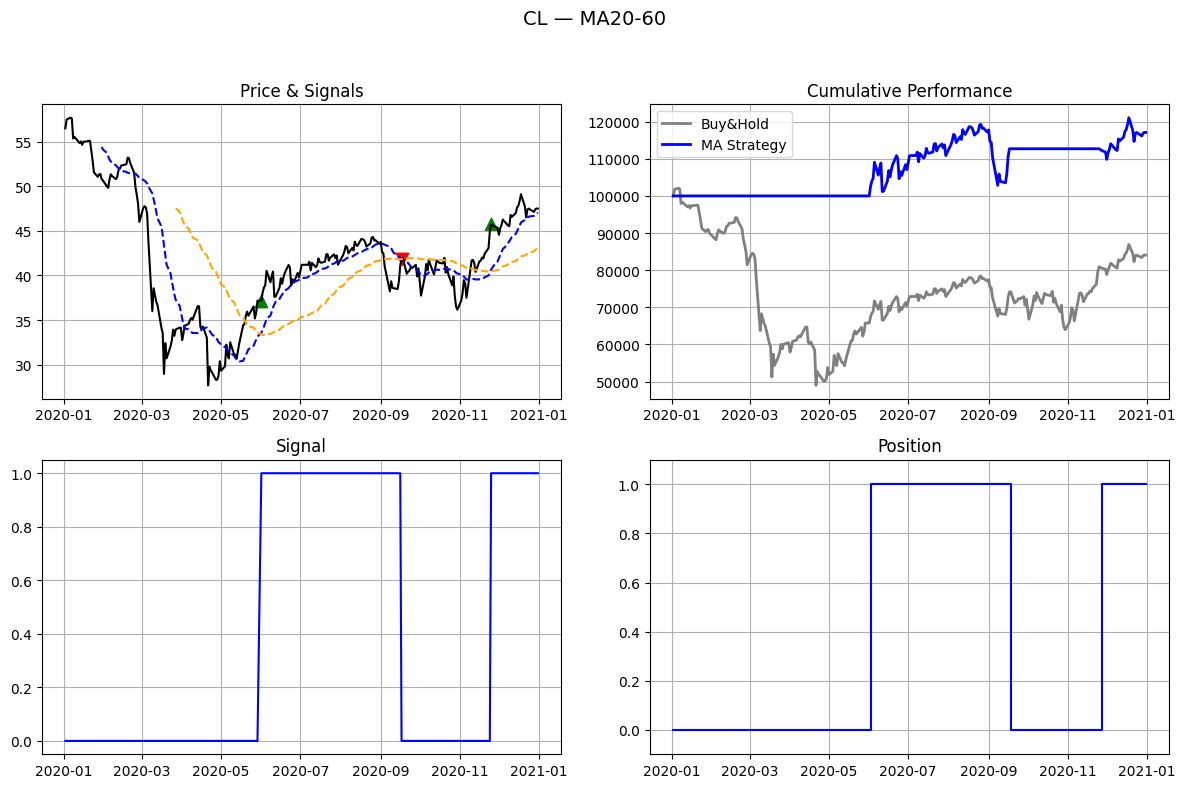

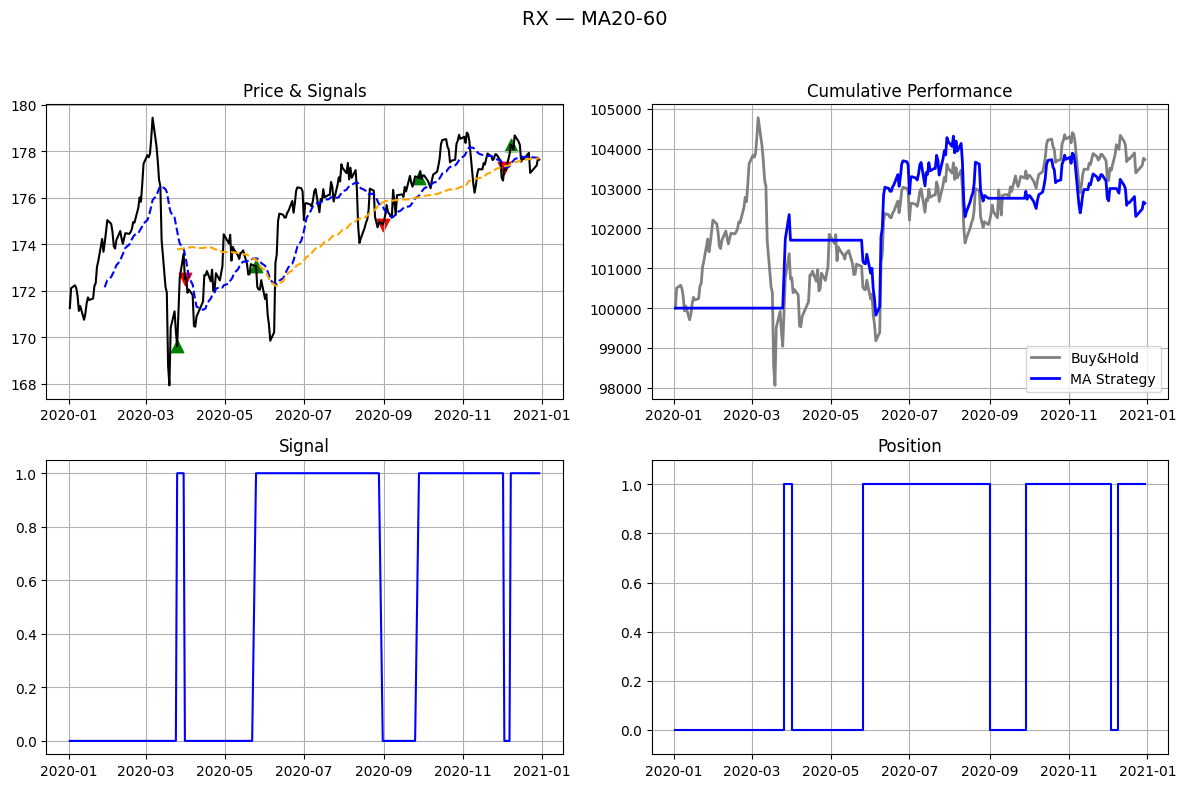

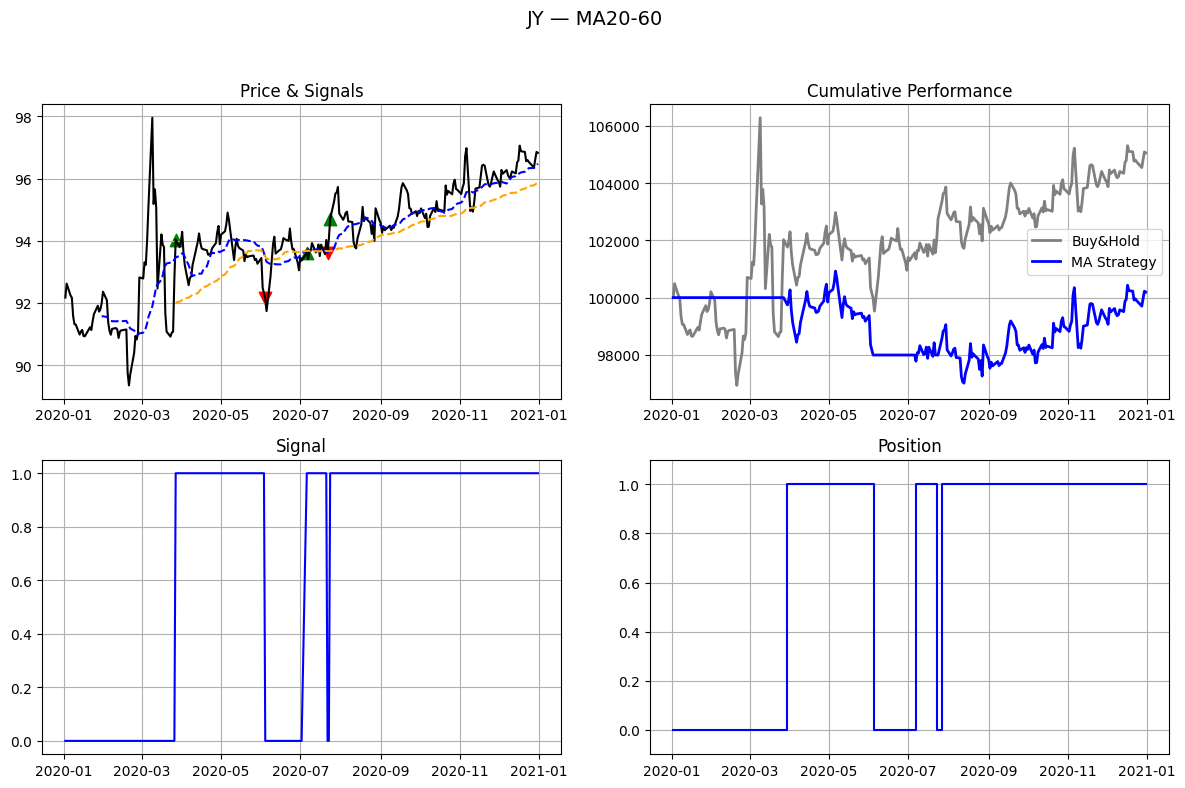

In [ ]:
def plot_ma(df, fast, slow, ticker):
    buys = df[df["Signal"].diff()==1]
    sells= df[df["Signal"].diff()==-1]
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    fig.suptitle(f"{ticker} — MA{fast}-{slow}", fontsize=14)

    # Price + arrows
    ax=axes[0,0]
    ax.plot(df.index,df["Price"],color="black")
    ax.plot(df.index,df["MA_fast"],"--",color="blue")
    ax.plot(df.index,df["MA_slow"],"--",color="orange")
    ax.scatter(buys.index,buys["Price"],marker="^",color="green",s=80)
    ax.scatter(sells.index,sells["Price"],marker="v",color="red",s=80)
    ax.set_title("Price & Signals"); ax.grid(True)

    # Signal
    ax=axes[1,0]
    ax.plot(df.index,df["Signal"],color="blue"); ax.set_title("Signal"); ax.grid(True)

    # Equity vs BH
    ax=axes[0,1]
    bh=(1+df["Price"].pct_change().fillna(0)).cumprod()*INITIAL_CAPITAL
    ax.plot(bh.index,bh,label="Buy&Hold",color="gray",linewidth=2)
    ax.plot(df.index,df["Equity"],label="MA Strategy",color="blue",linewidth=2)
    ax.set_title("Cumulative Performance"); ax.legend(); ax.grid(True)

    # Position
    ax=axes[1,1]
    ax.plot(df.index,df["Position"],drawstyle="steps-post",color="blue")
    ax.set_title("Position"); ax.set_ylim(-0.1,1.1); ax.grid(True)
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

print("📊 MA Visualizations:")
for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)
    for fast, slow in MA_PARAMS:
        ma_df,_,_ = ma_crossover(front, fast, slow)
        plot_ma(ma_df, fast, slow, ticker)
        print("\n\n\n\n\n")


# 2. Mean-reversion strategy – Relative Strength Index (RSI)

In [ ]:
# ─── STRATEGY: RSI Mean-Reversion ───
def rsi_strategy(front, lookback, low, high):
    df = front.copy()
    delta = df["Price"].diff()
    gain  = delta.clip(lower=0).rolling(lookback).mean()
    loss  = -delta.clip(upper=0).rolling(lookback).mean()
    # Handle division by zero when loss is 0
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    df.loc[loss == 0, "RSI"] = 0 # Set RSI to 0 when loss is 0

    df["Signal"] = 0
    df.loc[df["RSI"]<low, "Signal"]=1
    df.loc[df["RSI"]>high,"Signal"]=0
    df["Position"]      = df["Signal"].shift().fillna(0)
    df["Return"]        = df["Price"].pct_change().fillna(0)
    df["StrategyReturn"]= df["Position"]*df["Return"]
    df["Equity"]        = (1+df["StrategyReturn"]).cumprod()*INITIAL_CAPITAL
    trades = df["Signal"].diff().abs().sum()
    wins   = ((df["Position"]==1)&(df["Return"]>0)).sum()
    return df, int(trades), int(wins)

records_rsi = []
for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)
    for look, low, high in RSI_PARAMS:
        rsi_df, num_trades, winning_trades = rsi_strategy(front, look, low, high)
        metrics = performance_metrics(rsi_df["Equity"], rsi_df["StrategyReturn"])
        tr = metrics["TotalReturn(%)"]
        sr = metrics["Sharpe"]
        loss_trades = num_trades - winning_trades
        records_rsi.append({
            "Ticker":ticker,
            "RSI":f"{look}-{low}-{high}",
            "Total Ret (%)":tr,
            "Sharpe":sr,
            "Trades":num_trades,
            "Win Rate (%)": round(winning_trades/num_trades*100 if num_trades else 0,2),
            "W":winning_trades,
            "L":loss_trades,
            "Final Equity":round(rsi_df["Equity"].iloc[-1],2)
        })

summary_rsi = pd.DataFrame(records_rsi)
print("\n❇️ RSI Summary:\n")
print(summary_rsi.to_string(index=False))
print()


❇️ RSI Summary:

Ticker      RSI  Total Ret (%)    Sharpe  Trades  Win Rate (%)  W  L  Final Equity
    QZ 14-30-70     -12.455089 -0.673852      14         85.71 12  2      87544.91
    ES 14-30-70       0.301312  0.117752      10         90.00  9  1     100301.31
    CO 14-30-70     -20.895841 -0.663588      14        128.57 18 -4      79104.16
    CL 14-30-70     -13.939936 -0.260858      14        150.00 21 -7      86060.06
    RX 14-30-70       3.396490  1.176141       6        133.33  8 -2     103396.49
    JY 14-30-70       1.517820  0.910211       8         75.00  6  2     101517.82



<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_ret = (equity[-1]/equity[0] - 1)*100
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_ret = (equity[-1]/equity[0] - 1)*100
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_ret = (equity[-1]/equity[0] - 1)*100
<ipython-input-41-3905379258>:20: FutureWarning: Series.__getitem__


📊 RSI Visualizations:


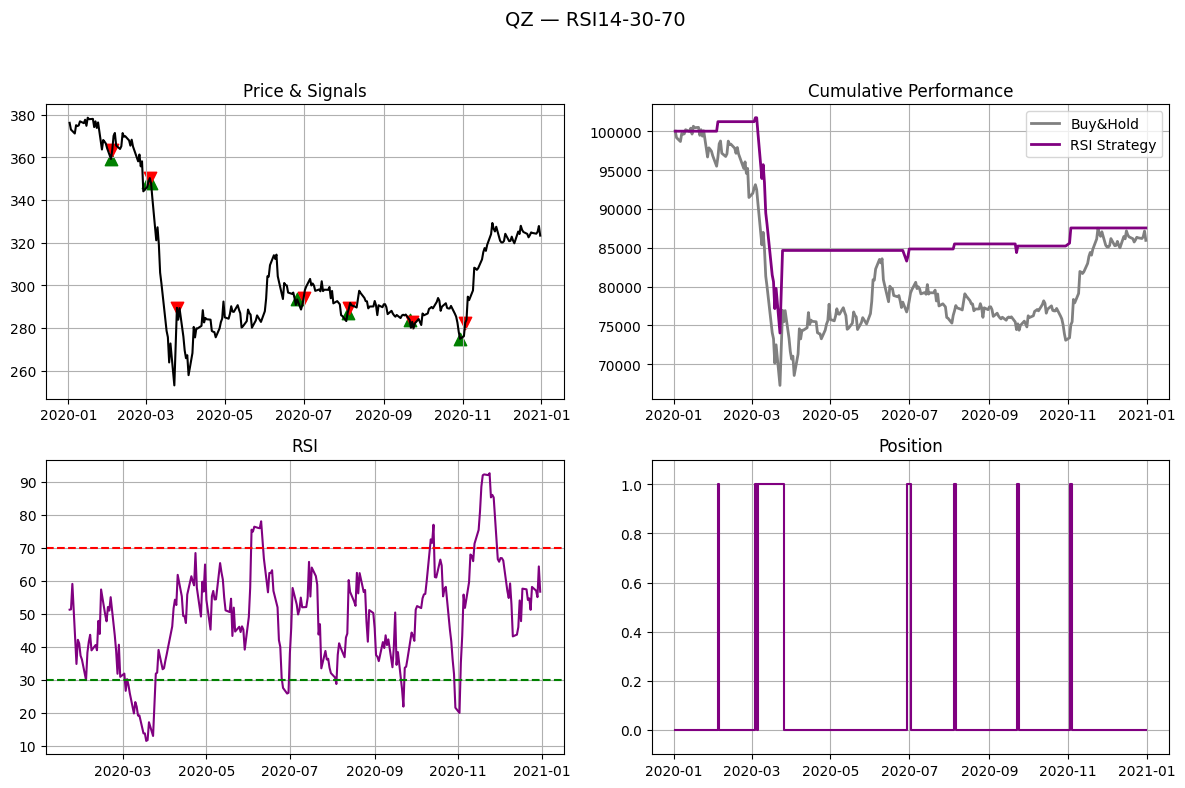

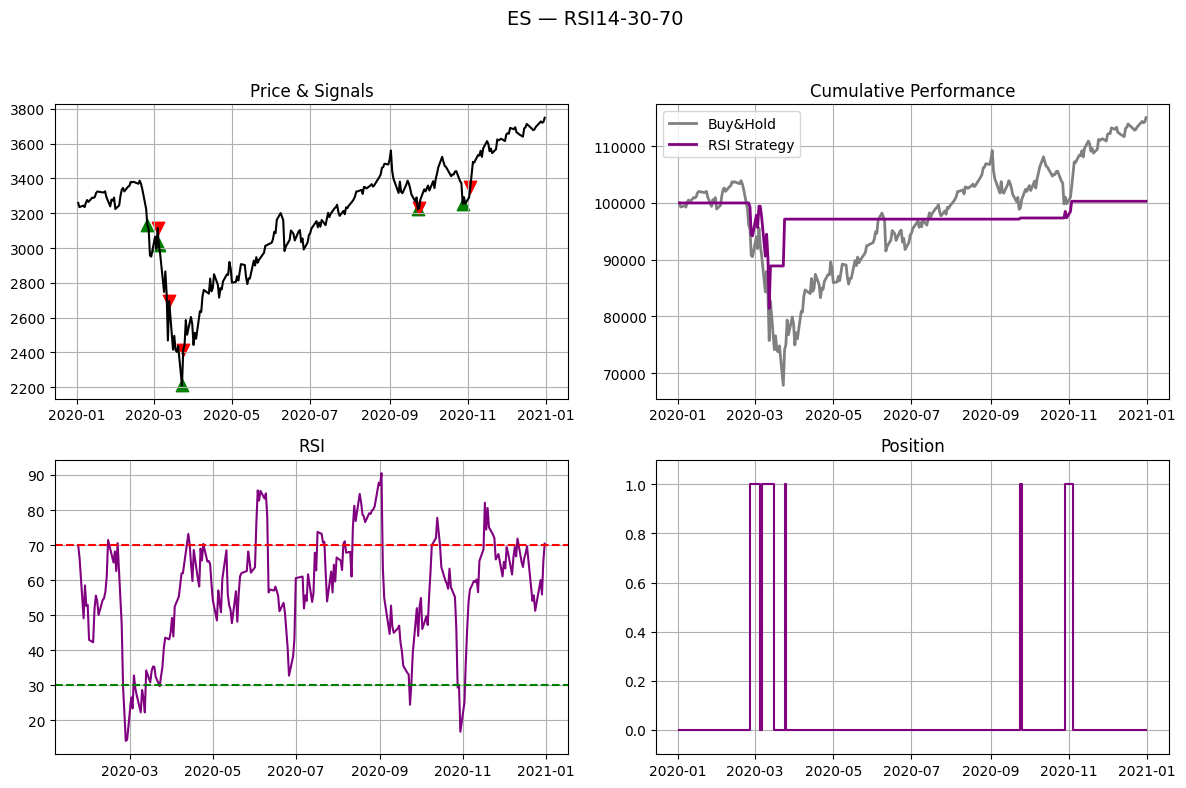

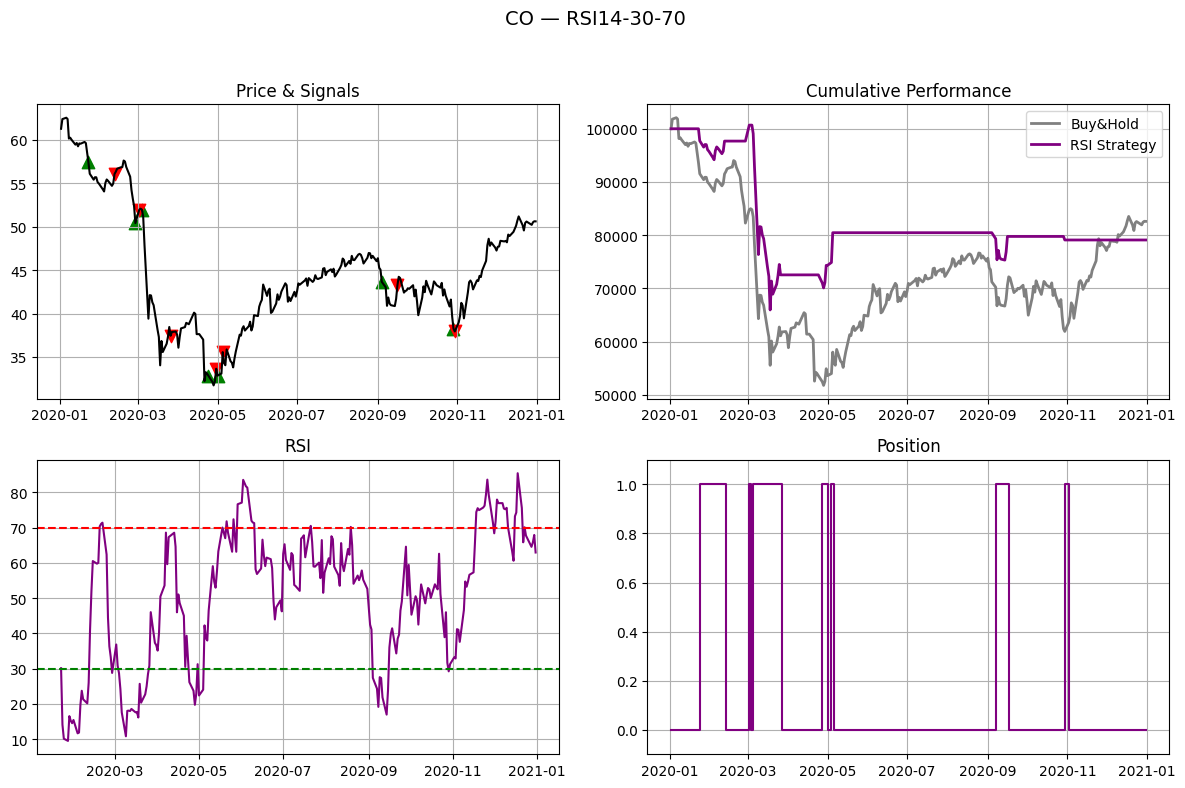

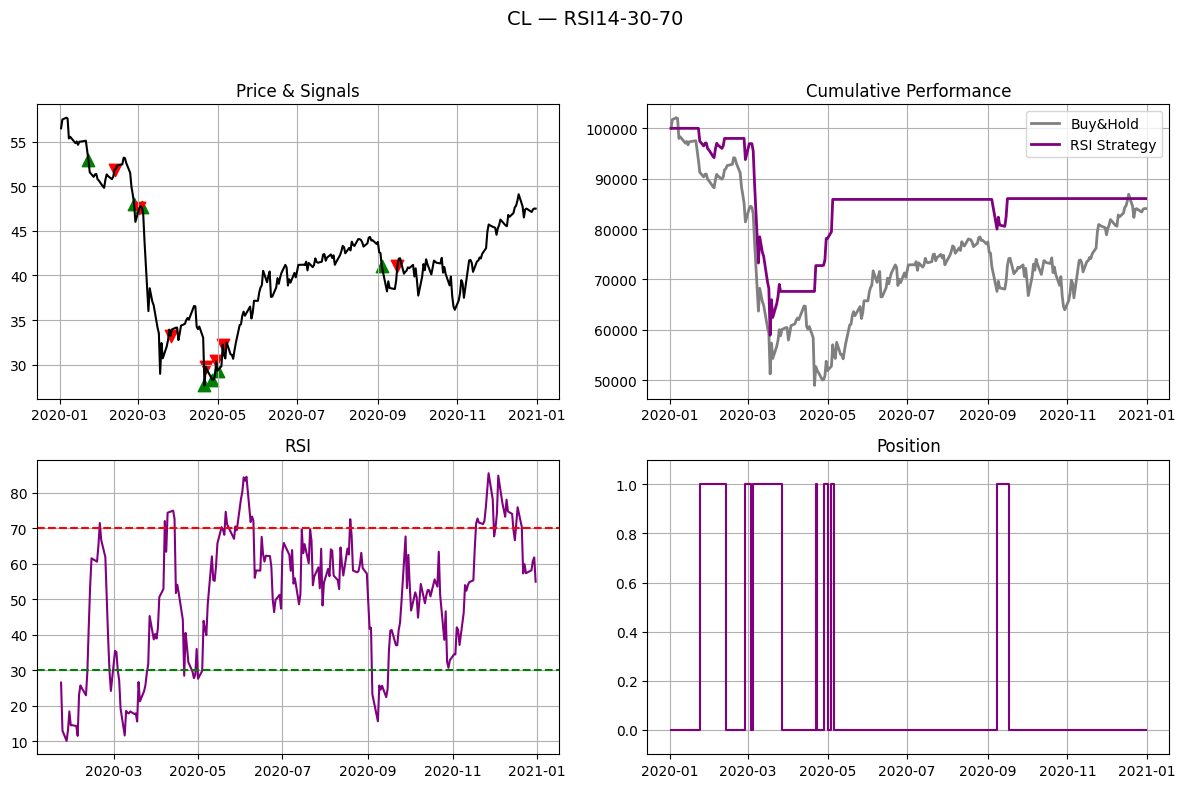

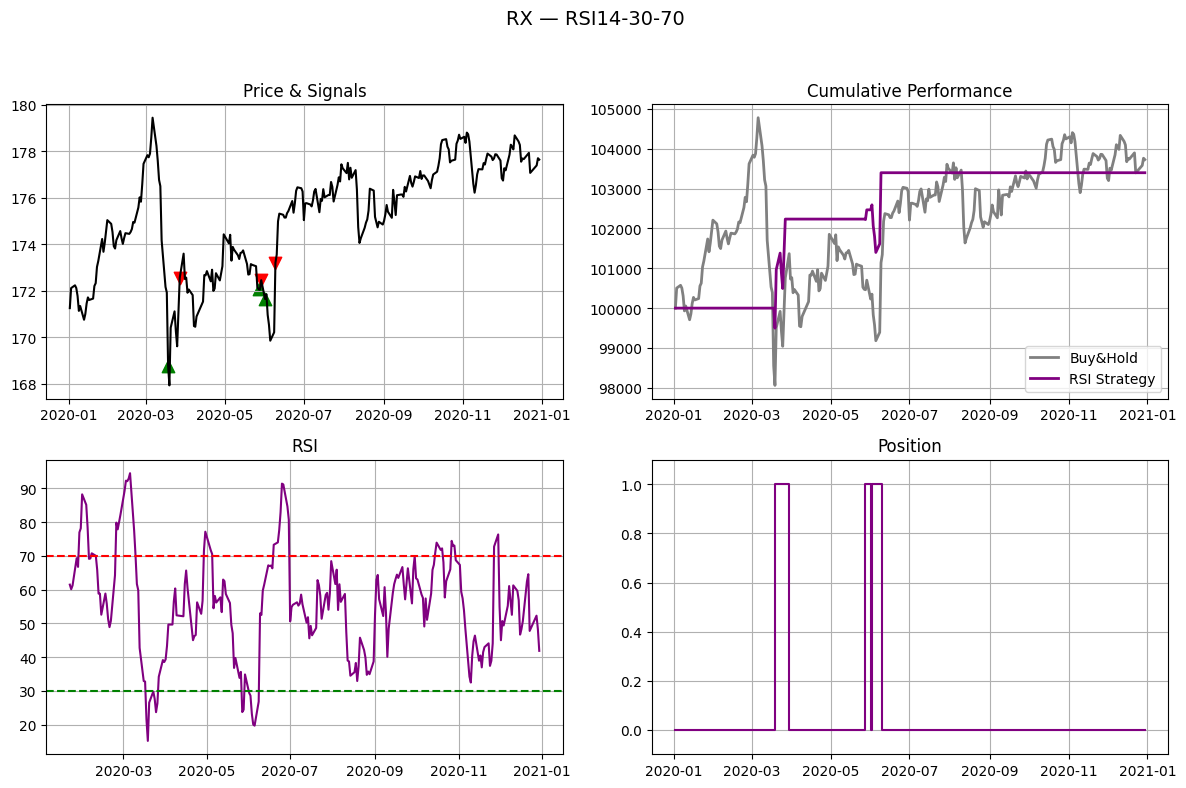

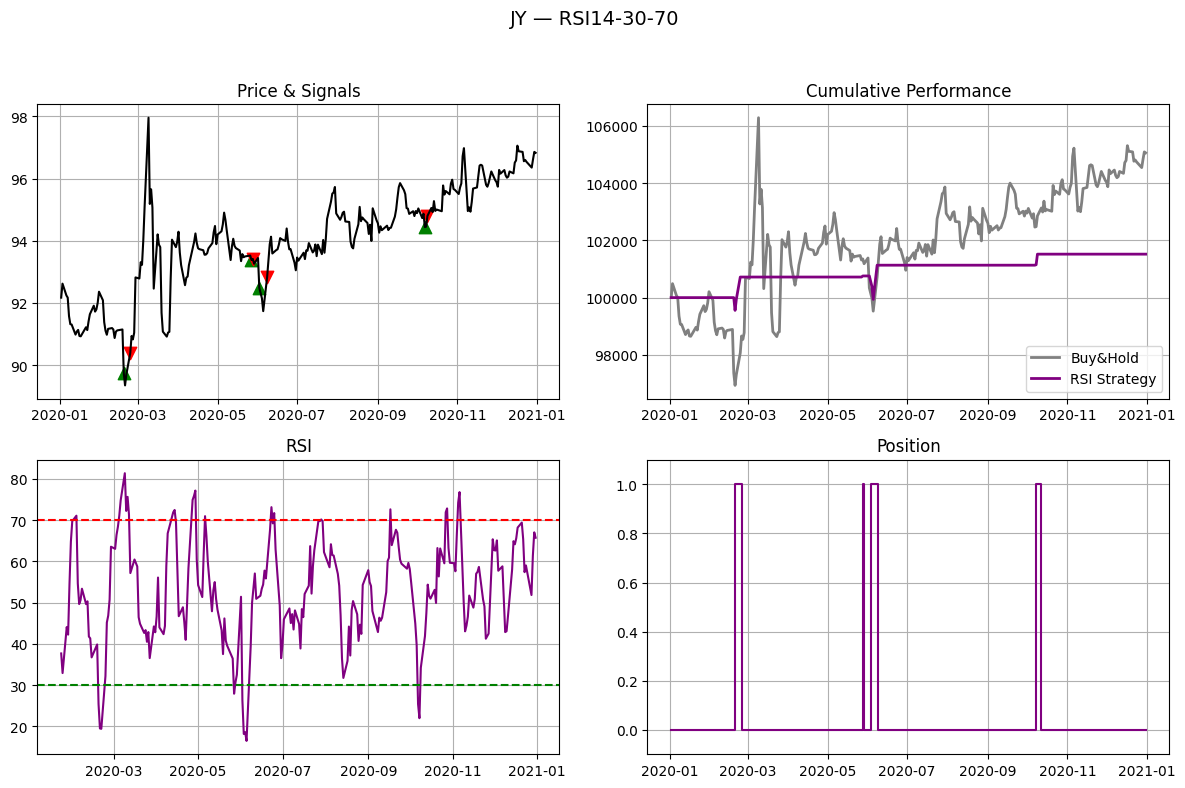

In [ ]:
def plot_rsi(df, look, low, high, ticker):
    buys  = df[df["Signal"].diff()==1]
    sells = df[df["Signal"].diff()==-1]
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    fig.suptitle(f"{ticker} — RSI{look}-{low}-{high}", fontsize=14)

    # Price + arrows
    ax=axes[0,0]
    ax.plot(df.index,df["Price"],color="black")
    ax.scatter(buys.index,buys["Price"],marker="^",color="green",s=80)
    ax.scatter(sells.index,sells["Price"],marker="v",color="red",s=80)
    ax.set_title("Price & Signals"); ax.grid(True)

    # Signal + RSI line
    ax=axes[1,0]
    ax.plot(df.index,df["RSI"],color="purple")
    ax.axhline(low,color="green",linestyle="--")
    ax.axhline(high,color="red",linestyle="--")
    ax.set_title("RSI"); ax.grid(True)

    # Equity vs BH
    ax=axes[0,1]
    bh=(1+df["Price"].pct_change().fillna(0)).cumprod()*INITIAL_CAPITAL
    ax.plot(bh.index,bh,label="Buy&Hold",color="gray",linewidth=2)
    ax.plot(df.index,df["Equity"],label="RSI Strategy",color="purple",linewidth=2)
    ax.set_title("Cumulative Performance"); ax.legend(); ax.grid(True)

    # Position
    ax=axes[1,1]
    ax.plot(df.index,df["Position"],drawstyle="steps-post",color="purple")
    ax.set_title("Position"); ax.set_ylim(-0.1,1.1); ax.grid(True)
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

print("\n📊 RSI Visualizations:")
for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)
    for look, low, high in RSI_PARAMS:
        rsi_df,_,_ = rsi_strategy(front, look, low, high)
        plot_rsi(rsi_df, look, low, high, ticker)
        print("\n\n\n\n\n")


In [ ]:
# ─────────── BLOCK 5️⃣: OVERALL SUMMARY ───────────

def performance_metrics_full(equity, strat_ret):
    total_ret   = (equity.iloc[-1] / equity.iloc[0] - 1) * 100
    sharpe      = strat_ret.mean() / strat_ret.std() * np.sqrt(TRADING_DAYS) if strat_ret.std()>0 else np.nan
    info_ratio  = sharpe
    peak        = equity.cummax()
    dd          = (equity - peak) / peak
    max_dd      = dd.min() * 100
    max_dd_date = dd.idxmin().date()
    return (
        round(total_ret,   2),
        round(sharpe,      2),
        round(info_ratio,  2),
        round(max_dd,      2),
        max_dd_date
    )

summary_all = []

for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)

    # MA runs
    for fast, slow in MA_PARAMS:
        ma_df, num_trades, winning_trades = ma_crossover(front, fast, slow)
        tr, sr, ir, md, md_date = performance_metrics_full(
            ma_df["Equity"], ma_df["StrategyReturn"]
        )
        num    = num_trades
        wins   = winning_trades
        losses = num - wins
        final_eq = ma_df["Equity"].iloc[-1]
        pnl      = round(final_eq - INITIAL_CAPITAL, 2)

        summary_all.append({
            "Ticker":              ticker,
            "Strategy":            f"MA{fast}-{slow}",
            "Total Return (%)":    tr,
            "Sharpe Ratio":        sr,
            "Information Ratio":   ir,
            "Max Drawdown (%)":    md,
            "Max Drawdown Date":   md_date,
            "Number of Trades":    num,
            "Win Rate (%)":        round(wins/num*100 if num else 0, 2),
            "Winning Trades":      wins,
            "Losing Trades":       losses,
            "Final Equity":        round(final_eq, 2),
            "Profit/Loss":         pnl
        })

    # RSI runs
    for look, low, high in RSI_PARAMS:
        rsi_df, num_trades, winning_trades = rsi_strategy(front, look, low, high)
        tr, sr, ir, md, md_date = performance_metrics_full(
            rsi_df["Equity"], rsi_df["StrategyReturn"]
        )
        num    = num_trades
        wins   = winning_trades
        losses = num - wins
        final_eq = rsi_df["Equity"].iloc[-1]
        pnl      = round(final_eq - INITIAL_CAPITAL, 2)

        summary_all.append({
            "Ticker":              ticker,
            "Strategy":            f"RSI{look}-{low}-{high}",
            "Total Return (%)":    tr,
            "Sharpe Ratio":        sr,
            "Information Ratio":   ir,
            "Max Drawdown (%)":    md,
            "Max Drawdown Date":   md_date,
            "Number of Trades":    num,
            "Win Rate (%)":        round(wins/num*100 if num else 0, 2),
            "Winning Trades":      wins,
            "Losing Trades":       losses,
            "Final Equity":        round(final_eq, 2),
            "Profit/Loss":         pnl
        })

# Build and display DataFrame
summary_df = pd.DataFrame(summary_all)
cols = [
    "Ticker","Strategy","Total Return (%)","Sharpe Ratio","Information Ratio",
    "Max Drawdown (%)","Max Drawdown Date","Number of Trades","Win Rate (%)",
    "Winning Trades","Losing Trades","Final Equity","Profit/Loss"
]
print("\nOverall Summary:\n")
print(summary_df[cols].to_string(index=False))

# Identify best by Total Return
best = summary_df.loc[summary_df["Total Return (%)"].idxmax()]
print(f"\nBest Overall Strategy: {best['Strategy']} on {best['Ticker']}"
      f" with {best['Total Return (%)']:.2f}% return")


Overall Summary:

Ticker    Strategy  Total Return (%)  Sharpe Ratio  Information Ratio  Max Drawdown (%) Max Drawdown Date  Number of Trades  Win Rate (%)  Winning Trades  Losing Trades  Final Equity  Profit/Loss
    QZ     MA20-60              4.08          0.40               0.40            -13.57        2020-10-30                 5        840.00              42            -37     104084.49      4084.49
    QZ RSI14-30-70            -12.46         -0.67              -0.67            -27.24        2020-03-23                14         85.71              12              2      87544.91    -12455.09
    ES     MA20-60             27.77          1.69               1.69             -9.47        2020-09-23                 3       3200.00              96            -93     127766.49     27766.49
    ES RSI14-30-70              0.30          0.12               0.12            -18.59        2020-03-12                10         90.00               9              1     100301.31       301.31
 


📈 Comparison Charts:


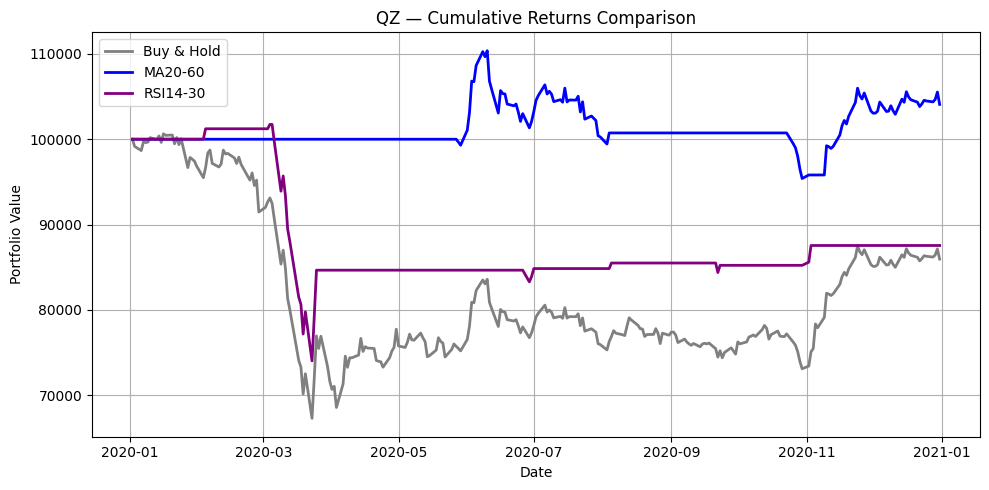

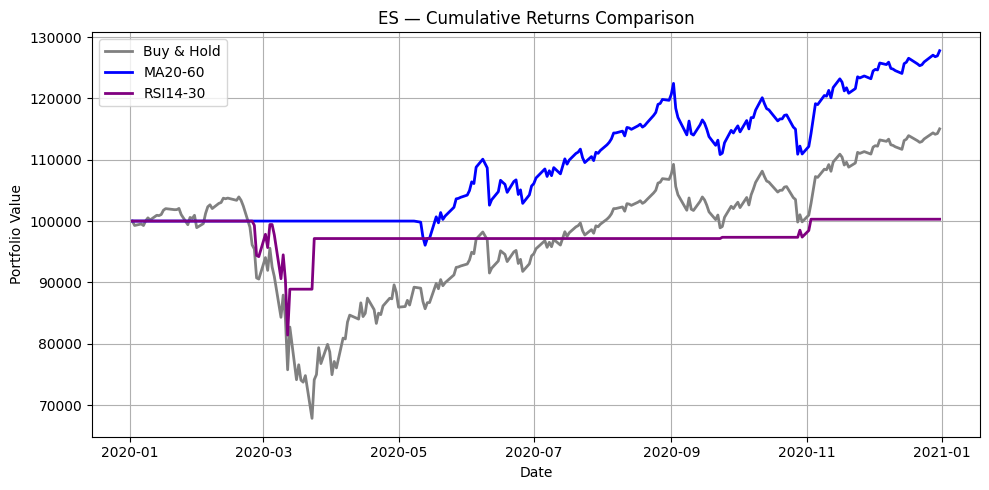

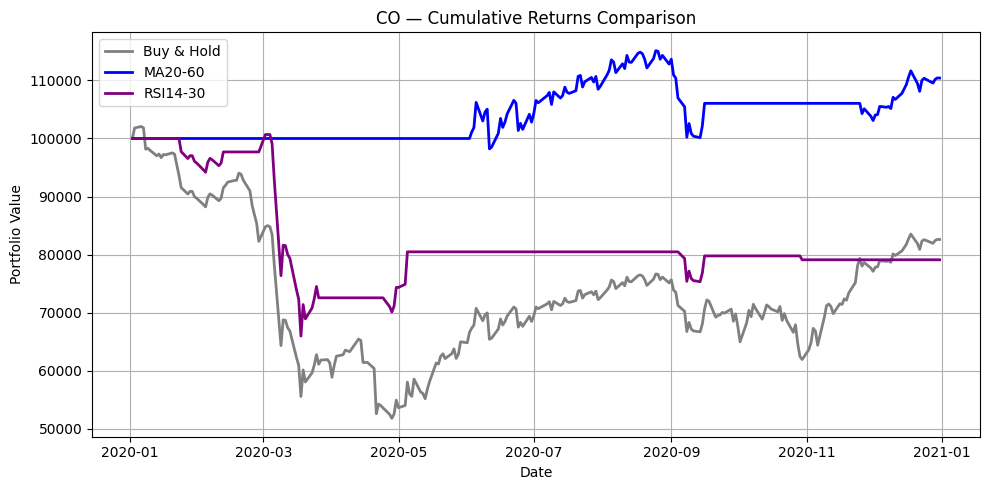

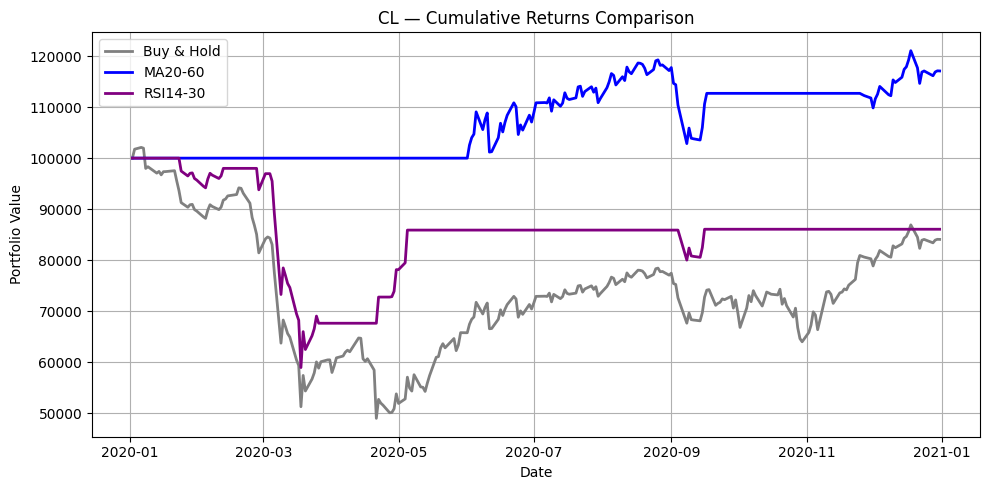

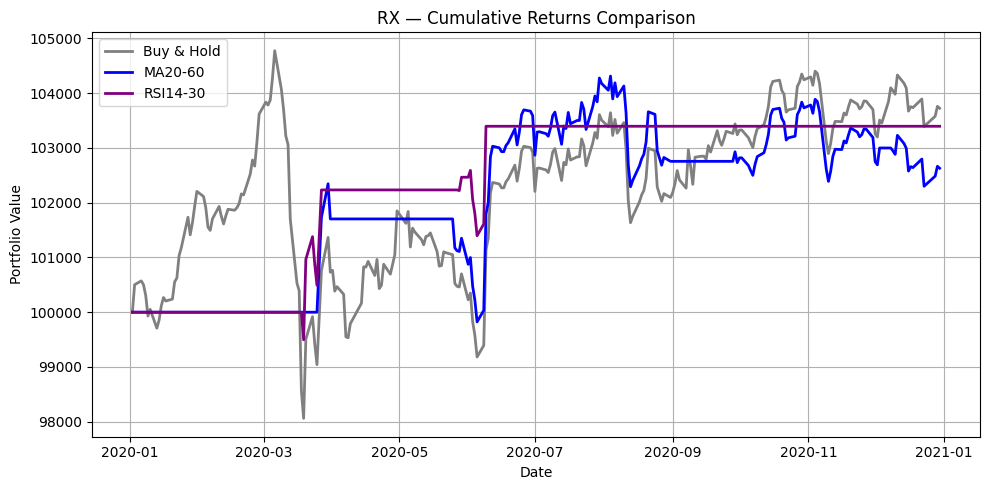

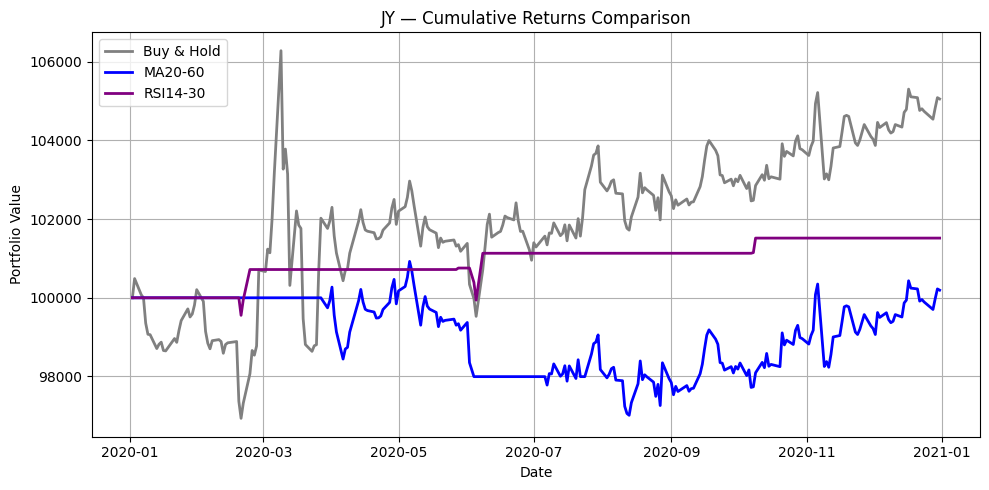

In [ ]:
print("\n📈 Comparison Charts:")
for ticker in TICKERS:
    front = build_front_month(df_raw, ticker)
    # pick the last MA and RSI runs
    ma_df, _, _  = ma_crossover(front, *MA_PARAMS[-1])
    rsi_df, _, _ = rsi_strategy(front, *RSI_PARAMS[-1])
    bh = (1+front["Price"].pct_change().fillna(0)).cumprod()*INITIAL_CAPITAL

    plt.figure(figsize=(10,5))
    plt.plot(bh.index, bh,               label="Buy & Hold", color="gray", linewidth=2)
    plt.plot(ma_df.index, ma_df["Equity"],   label=f"MA{MA_PARAMS[-1][0]}-{MA_PARAMS[-1][1]}", color="blue", linewidth=2)
    plt.plot(rsi_df.index, rsi_df["Equity"], label=f"RSI{RSI_PARAMS[-1][0]}-{RSI_PARAMS[-1][1]}", color="purple",linewidth=2)
    plt.title(f"{ticker} — Cumulative Returns Comparison")
    plt.xlabel("Date"); plt.ylabel("Portfolio Value")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# BONUS Task
Construct 3 portfolios made up of all 6 products, weighted equally by notional.

 ▪ Portfolio A: buy-and-hold futures

 ▪ Portfolio B: MA Crossover

 ▪ Portfolio C: RSI

In [ ]:
# Load raw data
df_raw = load_data(DATA_PATH)

returns_bh  = pd.DataFrame(index=pd.date_range(start="2020-02-01", end="2020-12-31"))
returns_ma  = returns_bh.copy()
returns_rsi = returns_bh.copy()

for t in TICKERS:
    front = build_front_month(df_raw, t)
    front = front.reindex(returns_bh.index).ffill()
    returns_bh[t]  = front["Price"].pct_change().fillna(0)
    ma_df, _, _ = ma_crossover(front, *MA_PARAMS[-1])
    returns_ma[t]  = ma_df["StrategyReturn"].reindex(returns_bh.index).fillna(0)
    rsi_df, _, _ = rsi_strategy(front, *RSI_PARAMS[-1])
    returns_rsi[t] = rsi_df["StrategyReturn"].reindex(returns_bh.index).fillna(0)

# Equal-weight portfolios
w_eq = np.ones(len(TICKERS))/len(TICKERS)
port_bh  = (returns_bh  @ w_eq).to_frame("PortfolioReturn")
port_ma  = (returns_ma  @ w_eq).to_frame("PortfolioReturn")
port_rsi = (returns_rsi @ w_eq).to_frame("PortfolioReturn")

# Performance metrics
def perf_metrics(ret):
    equity = (1+ret).cumprod()*INITIAL_CAPITAL
    total = (equity.iloc[-1]/INITIAL_CAPITAL-1)*100
    vol   = ret.std()*np.sqrt(TRADING_DAYS)*100
    sharpe= ret.mean()/ret.std()*np.sqrt(TRADING_DAYS)
    peak  = equity.cummax()
    dd    = (equity-peak)/peak
    maxdd = dd.min()*100
    dd_date_idx = dd.idxmin()
    dd_date = dd_date_idx.date() if pd.notna(dd_date_idx) else pd.NaT
    return total, round(sharpe,2), round(sharpe,2), round(maxdd,2), dd_date

perf = []
perf.append(("Portfolio A (BH)",) + perf_metrics(port_bh["PortfolioReturn"]))
perf.append(("Portfolio B (MA)",) + perf_metrics(port_ma["PortfolioReturn"]))
perf.append(("Portfolio C (RSI)",) + perf_metrics(port_rsi["PortfolioReturn"]))
perf_df = pd.DataFrame(perf, columns=["Portfolio","Total Return(%)","Sharpe Ratio", "Information Ratio","Max Drawdown(%)","Max DD Date"])
print("\n-----Equal-Weight Portfolios Performance-----\n")
print(perf_df.to_string(index=False))
print()

<ipython-input-41-3905379258>:3: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, dayfirst=True, parse_dates=["Date","Expiry"])



-----Equal-Weight Portfolios Performance-----

        Portfolio  Total Return(%)  Sharpe Ratio  Information Ratio  Max Drawdown(%) Max DD Date
 Portfolio A (BH)         3.012702          0.22               0.22           -24.59  2020-03-18
 Portfolio B (MA)        10.201217          1.00               1.00            -8.26  2020-10-30
Portfolio C (RSI)       -11.033101         -0.75              -0.75           -17.91  2020-03-18



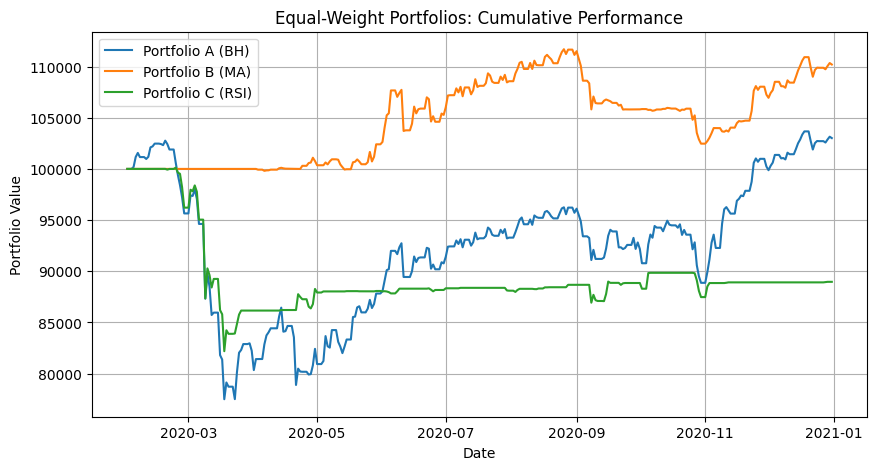

In [ ]:
# Plot equity curves
plt.figure(figsize=(10,5))
for name, df_port in zip(perf_df["Portfolio"], [port_bh, port_ma, port_rsi]):
    plt.plot(df_port.index, (1+df_port["PortfolioReturn"]).cumprod()*INITIAL_CAPITAL,
             label=name)
plt.title("Equal-Weight Portfolios: Cumulative Performance")
plt.xlabel("Date"); plt.ylabel("Portfolio Value"); plt.legend(); plt.grid(); plt.show()


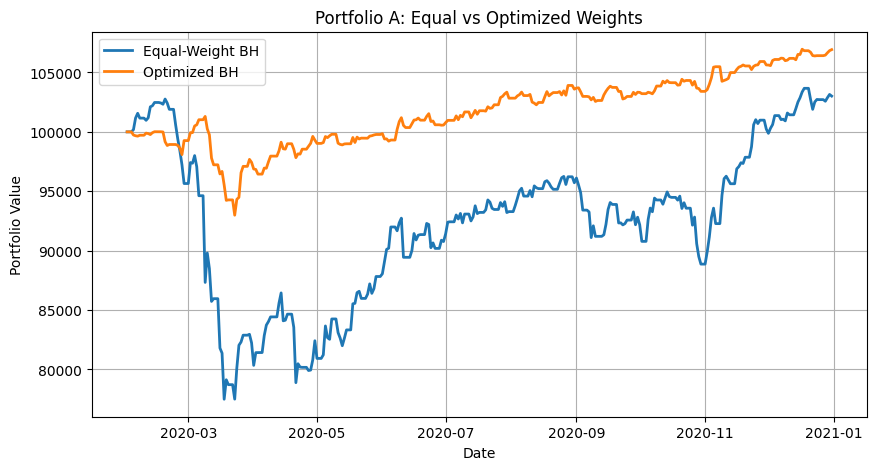

In [ ]:
# Fill any missing returns with zero so our dot‐product actually produces numbers
returns_bh_clean = returns_bh.fillna(0)

# Equal‐weight
port_bh  = (returns_bh_clean @ w_eq).to_frame("PortfolioReturn")

# Optimized‐weight (after you compute w_opt)
port_opt = returns_bh_clean.dot(w_opt.flatten()).to_frame("PortfolioReturn")

def perf_metrics_clean(ret):
    r = ret.dropna()
    equity = (1 + r).cumprod() * INITIAL_CAPITAL
    total = (equity.iloc[-1]/INITIAL_CAPITAL - 1)*100
    std   = r.std()
    sharpe = np.nan if std==0 else (r.mean()/std)*np.sqrt(TRADING_DAYS)
    # drawdown
    peak = equity.cummax()
    dd   = (equity - peak)/peak
    dd = dd.dropna()
    maxdd = dd.min()*100
    maxdd_date = dd.idxmin().date() if not dd.empty else pd.NaT
    return round(total,2), round(sharpe,2), round(sharpe,2), round(maxdd,2), maxdd_date

plt.figure(figsize=(10,5))
# equal‐weight
eq_curve  = (1+port_bh["PortfolioReturn"]).cumprod()*INITIAL_CAPITAL
# optimized
opt_curve = (1+port_opt["PortfolioReturn"]).cumprod()*INITIAL_CAPITAL

plt.plot(eq_curve.index,  eq_curve,  label="Equal-Weight BH",  linewidth=2)
plt.plot(opt_curve.index, opt_curve, label="Optimized BH", linewidth=2)

plt.title("Portfolio A: Equal vs Optimized Weights")
plt.xlabel("Date"); plt.ylabel("Portfolio Value")
plt.legend(); plt.grid(); plt.show()
